# Setup

In [128]:
import scipy
import math
import numpy as np
from diagonalize import State, delta, neg_1_pow, Interaction, Molecule
from sympy.physics.wigner import wigner_3j as sym_wigner_3j
import matplotlib.pyplot as pyplot

In [129]:
arr = np.load("jennoid.npy")
def T(n3, n1, m3, m1, n2, m2, N=10):
    m1_ = m1 + N
    m2_ = m2 + 2
    m3_ = m3 + N
    
    return m2_ + 5*n2 + 15*m1_ + (15 + 30*N)*m3_ + (15+ 60*N + 60*N*N)*n1 + (15 + 75*N + 120*N*N + 60 *N*N*N)*n3
    
def wigner_3j(n1, n2, n3, m1, m2, m3):
    return arr[T(n3,n1,m3,m1,n2,m2)]

In [130]:
h = scipy.constants.h
muN = scipy.constants.physical_constants['nuclear magneton'][0]
bohr = scipy.constants.physical_constants['Bohr radius'][0]
eps0 = scipy.constants.epsilon_0
c = scipy.constants.c
DebyeSI = 3.33564e-30

Na23Cs133 = {"I1":1.5,
            "I2":3.5,
            "g1":1.478,
            "g2":0.738,
            "d0":4.69*DebyeSI,
            "Brot":0.058*c*100*h,
            "Drot":0*h,
            "Q1":-0.097e6*h,
            "Q2":0.150e6*h,
            "C1":14.2*h,
            "C2":854.5*h,
            "C3":105.6*h,
            "C4":3941.8*h,
            "MuN":0*muN,
            "Mu1":1.478*muN,
            "Mu2":0.738*muN,
            "a0":0*h, #Not reported
            "a2":0*h, #Not reported
            "Beta":0}

def rotational(state1: State, state2:State):
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()

    if delta(n, n_) and delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_):
        return n*(n+1)
    return 0

def centrifugal(state1: State, state2:State):
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()

    if delta(n, n_) and delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_):
        return -n*(n+1)**2
    return 0

def quad_Na(state1: State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not delta(m2, m2_):
        return 0
    
    sum_term = 0
    for p in range(-2,3):
        wigp1 = wigner_3j(n, 2, n_, -mn, p, mn_)
        wigp2 = sym_wigner_3j(i1, 2, i1, -m1, -p, m1_)
        sum_term += neg_1_pow(p) * wigp1 * wigp2
    
    if sum_term == 0:
        return 0 
        
    wig3 = wigner_3j(n, 2, n_, 0, 0, 0)
    if wig3 == 0:
        return 0

    wig4 = sym_wigner_3j(i1, 2, i1, -i1, 0, i1)
    if wig4 == 0:
        raise("ArithmeticError; wigner coefficient is 0 but must be inverted")
    wig4 = 1.0/wig4
    
    other = neg_1_pow(-mn+i1-m1)*math.sqrt((2*n + 1) * (2*n_ + 1))/4

    return sum_term * wig3 * wig4 * other

def quad_Cs(state1:State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not delta(m1, m1_):
        return 0
    
    sum_term = 0
    for p in range(-2,3):
        wigp1 = wigner_3j(n, 2, n_, -mn, p, mn_)
        wigp2 = sym_wigner_3j(i2, 2, i2, -m2, -p, m2_)
        sum_term += neg_1_pow(p) * wigp1 * wigp2
    
    if sum_term == 0:
        return 0 
        
    wig3 = wigner_3j(n, 2, n_, 0, 0, 0)
    if wig3 == 0:
        return 0

    wig4 = sym_wigner_3j(i2, 2, i2, -i2, 0, i2)
    if wig4 == 0:
        raise("ArithmeticError; wigner coefficient is 0 but must be inverted")
    wig4 = 1.0/wig4
    
    other = neg_1_pow(-mn+i2-m2)*math.sqrt((2*n + 1) * (2*n_ + 1))/4

    return sum_term * wig3 * wig4 * other

def spin_rot_Na(state1:State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(n, n_) and delta(m2, m2_)):
        return 0
    
    sum_term = 0
    for p in range(-1,2):
        wigp1 = wigner_3j(n, 1, n, mn, p, -mn_)
        wigp2 = sym_wigner_3j(i1, 1, i1, m1, -p, -m1_)
        sum_term += wigp1 * wigp2 * neg_1_pow(p)
       
    if sum_term == 0:
        return 0
        
    other = neg_1_pow(n+mn_+i1+m1_) * math.sqrt(n * (n + 1) * (2*n + 1) * i1 * (i1 + 1) * (2*i1 + 1))
    if other == 0:
        return 0 

    return sum_term * other

def spin_rot_Cs(state1:State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(n, n_) and delta(m1, m1_)):
        return 0
    
    other = neg_1_pow(n+mn_+i2+m2_) * math.sqrt(n * (n + 1) * (2*n + 1) * i2 * (i2 + 1) * (2*i2 + 1))
    if other == 0:
        return 0 
    
    sum_term = 0
    for p in range(-1,2):
        wigp1 = wigner_3j(n, 1, n, mn, p, -mn_)
        wigp2 = sym_wigner_3j(i2, 1, i2, m2, -p, -m2_)
        sum_term += wigp1 * wigp2 * neg_1_pow(p)
    
    if sum_term == 0:
        return 0

    return sum_term * other

def nuc_spin_spin(state1: State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(n, n_) and delta(mn, mn_)):
        return 0
    
    other = neg_1_pow(i1+m1_+i2+m2_) * math.sqrt(i1 * (i1 + 1) * (2*i1 + 1) * i2 * (i2 + 1) * (2*i2 + 1))
    
    sum_term = 0
    for p in range(-1,2):
        wigp1 = sym_wigner_3j(i1, 1, i1, m1, p, -m1_)
        wigp2 = sym_wigner_3j(i2, 1, i2, m2, -p, -m2_)
        sum_term += wigp1 * wigp2 * neg_1_pow(p)
    
    if sum_term == 0:
        return 0

    return sum_term * other

def nuc_spin_spin_dip(state1: State, state2:State):
    i1 = 3/2
    i2 = 7/2

    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    sqrtpart = -math.sqrt(30 * i1 * (i1 + 1) * (2*i1 + 1) * i2 * (i2 + 1) * (2*i2 + 1) * (2*n + 1) * (2*n_ + 1))
    
    negpart = neg_1_pow(i1 + i1 - m1 - m2 - mn)
    
    wig0 = wigner_3j(n, 2, n_, 0, 0, 0)
    
    sum = 0
    
    for p in range(-1,2):
        wig1 = sym_wigner_3j(i2, 1, i2, -m2, -p, m2)
        
        for p1 in range(-1,2):
            for p2 in range(-1,2):
                
                wig2 = wigner_3j(n, 1, n_, -mn, p1, mn_)
                wig3 = sym_wigner_3j(i1, 1, i1, -m1, p2, m1_)
                wig4 = sym_wigner_3j(1, 2, 1, p1, p2, -p)
        sum += wig1 * wig2 * wig3 * wig4
        
    if sum == 0:
        return 0
    
    return sqrtpart * negpart * wig0 * sum

def stark(state1: State, state2:State):
    
    n, mn, m1, m2  = state1.get_state_vector()
    n_, mn_, m1_, m2_  = state2.get_state_vector()
    
    if not (delta(mn, mn_) and delta(m1, m1_) and delta(m2, m2_)):
        return 0
    
    wig1 = wigner_3j(n, 1, n_, -mn, 0, mn)
    if wig1 == 0:
        return 0
    
    wig2 = wigner_3j(n, 1, n_, 0, 0, 0)
    if wig2 == 0:
        return 0
    
    other = -neg_1_pow(mn+m1+m2) * math.sqrt((2*n + 1) * (2*n_ + 1))
    #print(state1,state2, other)
    
    return wig1 * wig2 * other

    

# Molecule Initialization

In [131]:
from scipy.constants import physical_constants
from scipy.constants import c
from scipy.constants import epsilon_0

int_rotational = Interaction(Na23Cs133["Brot"], rotational)
int_centrifugal = Interaction(Na23Cs133["Drot"], centrifugal)
int_quad_na = Interaction(Na23Cs133["Q1"], quad_Na)
int_quad_cs = Interaction(Na23Cs133["Q2"], quad_Cs)

const_nuc_spin_spin_dip = Na23Cs133["g1"] * Na23Cs133["g2"] * physical_constants["nuclear magneton"][0]**2 / (4 * math.pi * epsilon_0 * c * c)
int_nuc_spin_spin_dip = Interaction(const_nuc_spin_spin_dip, nuc_spin_spin_dip)
int_nuc_spin_spin = Interaction(Na23Cs133["C4"], nuc_spin_spin)
int_spin_rot_Na = Interaction(Na23Cs133["C1"], spin_rot_Na)
int_spin_rot_Cs = Interaction(Na23Cs133["C2"], spin_rot_Cs)
int_stark = Interaction(Na23Cs133["d0"], stark)

In [132]:
NaCs = Molecule([0,1,2], 3/2, 7/2)

NaCs.add_interaction(int_rotational)
#NaCs.add_interaction(int_centrifugal)
NaCs.add_interaction(int_quad_na)
NaCs.add_interaction(int_quad_cs)
NaCs.add_interaction(int_nuc_spin_spin)
NaCs.add_interaction(int_nuc_spin_spin_dip)
NaCs.add_interaction(int_spin_rot_Na)
NaCs.add_interaction(int_spin_rot_Cs)
NaCs.add_changing_interaction(int_stark)

H has dim 288


In [133]:
NaCs.find_H_zero()
NaCs.find_H_prime()

E_range = np.linspace(0, 5, int(60)) * 1e5
eigenvalues_and_eigenvectors = NaCs.compute_eigenval_over_range([E_range])
eigenvalues_to_plot = []
for elem in eigenvalues_and_eigenvectors:
    eigenvalues_to_plot.append(np.sort(np.real_if_close(elem[0].copy()))[:])
myenergies = np.array(eigenvalues_to_plot)

# Working

Text(0, 0.5, 'My Energy/h (MHz)')

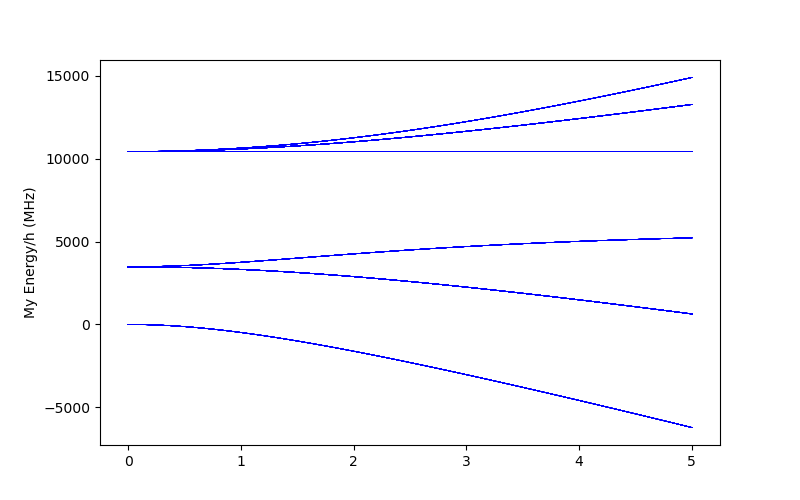

In [134]:
%matplotlib ipympl

pyplot.close()

fig, ax = pyplot.subplots(figsize=(8, 5))

ax.plot(E_range*1e-5, myenergies[:,:]*1e-6/h, color='b', linewidth=0.5)
ax.set_ylabel("My Energy/h (MHz)")


In [57]:
def T(n3, n1, m3, m1, n2, m2, N=10):
    m1_ = m1 + N
    m2_ = m2 + 2
    m3_ = m3 + N
    
    return m2_ + 5*n2 + 15*m1_ + (15 + 30*N)*m3_ + (15+ 60*N + 60*N*N)*n1 + (15 + 75*N + 120*N*N + 60 *N*N*N)*n3

In [58]:
11*11*21*21*3*5

800415

In [60]:
N = 10
prevvec = [0, 0, 0, -10, -2, -10]
prevval = -1
count = 0
valmax = 0
for n3 in range(0, N+1):
    for n1 in range(0, N+1):
        for m3 in range(-N, N+1):
            for m1 in range(-N, N+1):
                for n2 in range(0, 3):
                    for m2 in range(-2,3):
                        count += 1
                        val = T(n3, n1, m3, m1, n2, m2)
                        if val != prevval + 1:
                            print("Break in order")
                            print(prevvec)
                            print([n3, n1, m3, m1, n2, m2])
                            print(prevval, val)
                        prevval = val
                        prevvec = [n3, n1, m3, m1, n2, m2]
                        if val > valmax:
                            valmax = val
print(count)
print(val)
print(valmax)

800415
800414
800414


In [68]:
np.save("jennoid.npy", [0,1,2,3,4,5,6,7]*100000)

In [71]:
arr = np.load("jennoid.npy")


In [73]:
arr.size

800415

In [81]:
n1, n2, n3, m1, m2, m3 = 1, 0, 1, -1, 0, 1


sqrt(3)/3
0.5773502691896257


In [90]:
for i in range(1000000):
    wigner_3j(n1,n2,n3,m1,m2,m3)

In [91]:
for i in range(1000000):
    arr[T(n3,n1,m3,m1,n2,m2)]

In [95]:
disagree = False
for n3 in range(0, N+1):
    for n1 in range(0, N+1):
        for m3 in range(-N, N+1):
            for m1 in range(-N, N+1):
                for n2 in range(0, 3):
                    for m2 in range(-2,3):
                        if abs(wigner_3j(n1,n2,n3,m1,m2,m3) - arr[T(n3,n1,m3,m1,n2,m2)]) > 0.0000001:
                            disagree = True
print(disagree)

False
